<a href="https://colab.research.google.com/github/nikishkaaa/Bank_Customer_Churn_Prediction_ML/blob/main/Bank_Customer_Churn_Prediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Problem Statement:
Customer churn is a critical issue for banks, as it directly impacts revenue and growth. This project aims to predict whether a customer will leave the bank using a dataset containing various customer attributes and transaction history. By accurately predicting churn, the bank can implement targeted retention strategies, thereby improving customer satisfaction and reducing loss.

# Installing all libraries and exploring the dataset

In [1]:
!pip install opendatasets --upgrade --quiet

In [26]:
import opendatasets as od
import numpy as np
import pandas as pd
import os
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import OneHotEncoder
import matplotlib.pyplot as plt
from sklearn.neighbors import KNeighborsClassifier
from process_bank_churn import preprocess_data
from sklearn.metrics import roc_auc_score, confusion_matrix, roc_curve, auc
from sklearn.model_selection import GridSearchCV,RandomizedSearchCV
from sklearn.tree import DecisionTreeClassifier
import seaborn as sns
from sklearn.linear_model import  LogisticRegression
from sklearn.svm import SVC

In [3]:
dataset_url = 'https://www.kaggle.com/competitions/bank-customer-churn-prediction-dlu/data'
od.download(dataset_url)

Skipping, found downloaded files in "./bank-customer-churn-prediction-dlu" (use force=True to force download)


In [30]:
raw_data = pd.read_csv('bank-customer-churn-prediction-dlu/train.csv')
raw_data.head()

,id,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,0,15779985.0,Nwankwo,678.0,France,Male,29.0,4.0,0.00,3.0,1.0,0.0,180626.36,0.0
1,1,15650086.0,Ch'in,687.0,France,Female,34.0,1.0,0.00,2.0,0.0,1.0,63736.17,0.0
2,2,15733602.0,Thompson,682.0,France,Female,52.0,6.0,0.00,3.0,0.0,0.0,179655.87,1.0
3,3,15645794.0,Macleod,753.0,Germany,Male,44.0,6.0,83347.25,2.0,1.0,0.0,161407.48,0.0
4,4,15633840.0,Hsia,544.0,Germany,Female,55.0,0.0,107747.57,1.0,1.0,0.0,176580.86,1.0


In [5]:
raw_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15000 entries, 0 to 14999
Data columns (total 14 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   id               15000 non-null  int64  
 1   CustomerId       15000 non-null  float64
 2   Surname          15000 non-null  object 
 3   CreditScore      15000 non-null  float64
 4   Geography        15000 non-null  object 
 5   Gender           15000 non-null  object 
 6   Age              15000 non-null  float64
 7   Tenure           15000 non-null  float64
 8   Balance          15000 non-null  float64
 9   NumOfProducts    15000 non-null  float64
 10  HasCrCard        15000 non-null  float64
 11  IsActiveMember   15000 non-null  float64
 12  EstimatedSalary  15000 non-null  float64
 13  Exited           15000 non-null  float64
dtypes: float64(10), int64(1), object(3)
memory usage: 1.6+ MB


In [6]:
raw_data.describe()

,id,CustomerId,CreditScore,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
count,15000.000000,1.500000e+04,15000.000000,15000.000000,15000.000000,15000.000000,15000.000000,15000.000000,15000.000000,15000.000000,15000.000000
mean,7499.500000,1.569146e+07,658.944133,37.739600,5.025267,42729.791988,1.590933,0.788800,0.489667,117784.666193,0.203467
std,4330.271354,1.352050e+05,72.255926,8.218363,2.776678,59727.309419,0.532306,0.408174,0.499910,45734.445888,0.402590
min,0.000000,1.581102e+06,431.000000,18.000000,0.000000,0.000000,1.000000,0.000000,0.000000,11.580000,0.000000
25%,3749.750000,1.563514e+07,603.000000,32.000000,3.000000,0.000000,1.000000,1.000000,0.000000,83058.140000,0.000000
50%,7499.500000,1.569018e+07,662.000000,37.000000,5.000000,0.000000,2.000000,1.000000,0.000000,123584.870000,0.000000
75%,11249.250000,1.575718e+07,708.000000,42.000000,7.000000,109531.017500,2.000000,1.000000,1.000000,156884.705000,0.000000
max,14999.000000,1.581569e+07,850.000000,74.000000,10.000000,209767.310000,4.000000,1.000000,1.000000,199992.480000,1.000000


In [31]:
pal = sns.color_palette("Spectral")
sns.set_palette(pal)

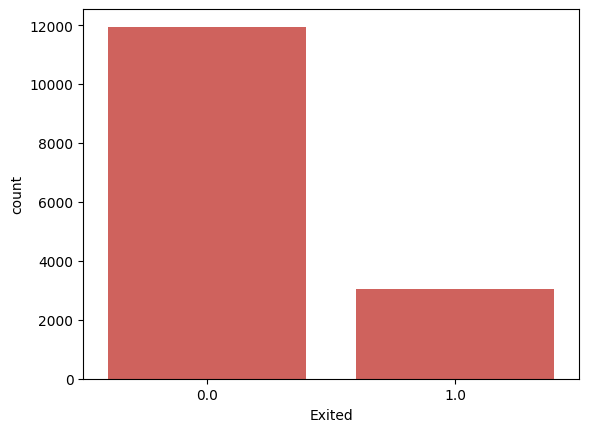

In [32]:
sns.countplot(x = 'Exited', data=raw_data)
plt.show()

In [33]:
numeric_cols = [
 'Age',
 'Balance',
 'CreditScore',
 'IsActiveMember',
 'EstimatedSalary']
categorical_cols = ['Geography', 'Gender','NumOfProducts' ]

## Splitting to train and test using .py file with preprocessing

In [34]:
data =  preprocess_data(raw_data, 'Exited', scaler_numeric=True, categorical_cols=categorical_cols,numeric_cols = numeric_cols)
X_train = data['X_train']
y_train = data['train_targets']
X_val = data['X_val']
y_val= data['val_targets']

# Logistic Regression

In [35]:
model = LogisticRegression(solver = 'liblinear')
model.fit(X_train, y_train)

LogisticRegression(solver='liblinear')

In [36]:
trains_pred = model.predict(X_train)
trains_pred

array([0., 0., 0., ..., 0., 0., 0.])

In [37]:
val_preds = model.predict(X_val)
val_preds

array([1., 0., 0., ..., 0., 0., 0.])

### Confusion matrix

In [38]:
confusion_matrix(y_train, trains_pred)

array([[9140,  418],
       [ 862, 1580]])

In [39]:
confusion_matrix(y_val, val_preds)

array([[2267,  123],
       [ 207,  403]])

#### ROC Curve + AUROC

In [40]:
def compute_auroc_and_build_roc(model, inputs, targets, name=''):
  # Predict probabilities
  y_pred_proba = model.predict_proba(inputs)[:, 1]

  # Compute ROC curve
  fpr, tpr, thresholds = roc_curve(targets, y_pred_proba, pos_label=1.0)

    # Compute AUROC
  roc_auc = auc(fpr, tpr)
  print(f'AUROC for {name}: {roc_auc:.2f}')

  # Plot the ROC curve
  plt.figure()
  plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
  plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
  plt.xlim([0.0, 1.0])
  plt.ylim([0.0, 1.05])
  plt.xlabel('False Positive Rate')
  plt.ylabel('True Positive Rate')
  plt.title(f'Receiver Operating Characteristic (ROC) Curve for {name}')
  plt.legend(loc="lower right")
  plt.show()

In [41]:
y_pred_proba = model.predict_proba(X_train)[:, 1]
y_pred_proba

array([0.01510262, 0.22376945, 0.04143792, ..., 0.00316166, 0.06918303,
       0.02094629])

In [42]:
fpr, tpr, thresholds = roc_curve(y_train, y_pred_proba, pos_label=1.0)
fpr, tpr, thresholds

(array([0.        , 0.        , 0.        , ..., 0.99466416, 0.99466416,
        1.        ]),
 array([0.00000000e+00, 4.09500410e-04, 3.35790336e-02, ...,
        9.99590500e-01, 1.00000000e+00, 1.00000000e+00]),
 array([           inf, 9.99613430e-01, 9.87036153e-01, ...,
        1.10269073e-03, 1.09444579e-03, 3.51498278e-04]))

AUROC for Training: 0.93


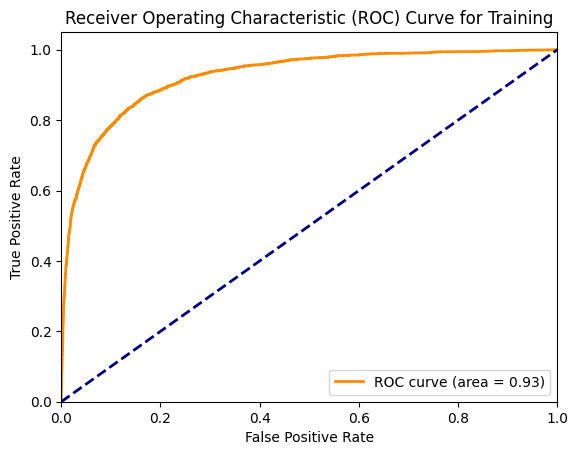

AUROC for Validation: 0.92


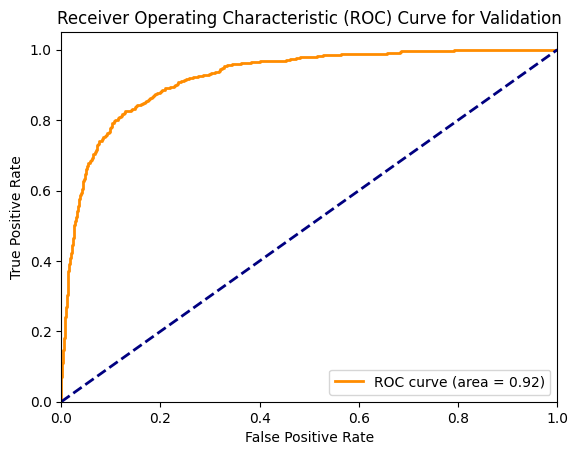

In [43]:
compute_auroc_and_build_roc(model, X_train, y_train, 'Training')
compute_auroc_and_build_roc(model, X_val, y_val, 'Validation')

#### Conclusion: The model performs very well, as AUROC = 0.92, and the difference between the metric scores for the training and validation datasets is minimal.

#KNN

In [46]:
svm = SVC(kernel='sigmoid', probability=True)
svm.fit(X_train, y_train)

train_preds = svm.predict(X_train)
test_preds = svm.predict(X_val)

AUROC for Training: 0.75


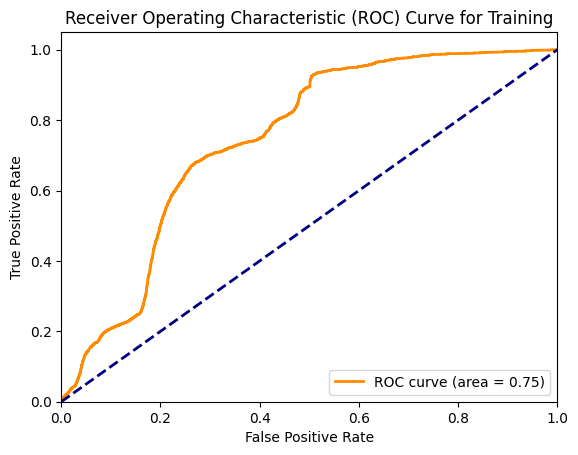

AUROC for Validation: 0.75


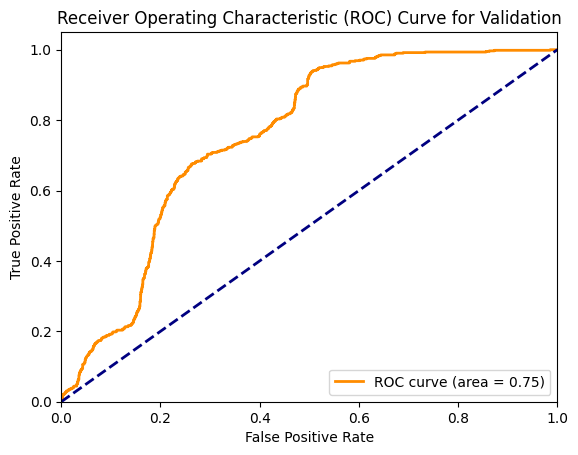

In [47]:
compute_auroc_and_build_roc(svm, X_train, y_train, 'Training')
compute_auroc_and_build_roc(svm, X_val, y_val, 'Validation')

#### Best hyperparameters searching with GridSearchCV

In [50]:
svm_model = SVC(probability=True)

param_grid = {
    'kernel': ['sigmoid', 'linear', 'poly', 'rbf']
}

grid_search = GridSearchCV(estimator=svm_model, param_grid=param_grid, scoring='roc_auc', cv=5, n_jobs=-1)

grid_search.fit(X_train, y_train)

print("Best parameters found: ", grid_search.best_params_)
print("Best AUROC score: ", grid_search.best_score_)


best_model = grid_search.best_estimator_


train_preds = best_model.predict_proba(X_train)[:, 1]
test_preds = best_model.predict_proba(X_val)[:, 1]

print('Train AUROC =', roc_auc_score(y_train, train_preds))
print('Test AUROC =', roc_auc_score(y_val, test_preds))

Best parameters found:  {'kernel': 'linear'}
Best AUROC score:  0.9239781236082475
Train AUROC = 0.9245296914788441
Test AUROC = 0.9203861718910762


#### Conclusion: GridSearchCV found the best hyperparameters for SVM model. So, the model performs very well, as AUROC = 0.92, and the difference between the metric scores for the training and validation datasets is minimal.